In [1]:
from fastai.text import *
import html
import pandas as pd
from src.text_tools import fixup, get_texts, get_all
from sklearn.utils import class_weight
%load_ext autoreload
%autoreload 2

In [2]:
PATH=('/contents')
LM_PATH=Path('/contents/data/lm/')
CLAS_PATH=Path('/contents/data/clas/')

In [3]:
chunksize = 24000
df_trn = pd.read_csv(CLAS_PATH/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(CLAS_PATH/'test.csv', header=None, chunksize=chunksize)

In [4]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

0
0


In [5]:
(CLAS_PATH/'tmp').mkdir(exist_ok=True)
np.save(CLAS_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(CLAS_PATH/'tmp'/'tok_val.npy', tok_val)
np.save(CLAS_PATH/'tmp'/'trn_labels.npy', trn_labels)
np.save(CLAS_PATH/'tmp'/'val_labels.npy', val_labels)

In [6]:
tok_trn = np.load(CLAS_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(CLAS_PATH/'tmp'/'tok_val.npy')

In [7]:
itos = pickle.load((LM_PATH/'tmp'/'itos.pkl').open('rb'))
#have to use the Language Model integers to strings
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

39286

In [8]:
trn_clas = np.array([[stoi[o] for o in p] for p in tok_trn])
val_clas = np.array([[stoi[o] for o in p] for p in tok_val])

In [9]:
np.save(CLAS_PATH/'tmp'/'trn_ids.npy', trn_clas)
np.save(CLAS_PATH/'tmp'/'val_ids.npy', val_clas)

In [10]:
trn_clas = np.load(CLAS_PATH/'tmp'/'trn_ids.npy')
val_clas = np.load(CLAS_PATH/'tmp'/'val_ids.npy')
trn_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'trn_labels.npy'))
val_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'val_labels.npy'))

In [11]:
cls_wgts = class_weight.compute_class_weight('balanced',\
                                                   np.unique(trn_labels),(trn_labels))
cls_wgts = torch.cuda.FloatTensor(cls_wgts)
print(cls_wgts)


 20.9854
  0.3659
  4.5620
[torch.cuda.FloatTensor of size 3 (GPU 0)]



In [12]:
bptt,em_sz,nh,nl = 70,400,1150,3
vs = len(itos)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
bs = 52

In [13]:
min_lbl = trn_labels.min() #sets the labels to start from 0
trn_labels -= min_lbl
val_labels -= min_lbl
c = int(trn_labels.max())+1 #number of labels

In [14]:
trn_ds = TextDataset(trn_clas, trn_labels)
val_ds = TextDataset(val_clas, val_labels)
trn_samp = SortishSampler(trn_clas, key=lambda x: len(trn_clas[x]), bs=bs//2)
val_samp = SortSampler(val_clas, key=lambda x: len(val_clas[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=1, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=val_samp)
md = ModelData(PATH, trn_dl, val_dl)

In [15]:
drop_factor = 0.8
dps = np.array([0.4,0.5,0.05,0.3,0.4])*drop_factor

In [16]:
m = get_rnn_classifer(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
          layers=[em_sz*3, 50, c], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

In [17]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [18]:
learn = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
learn.crit = nn.CrossEntropyLoss(weight=cls_wgts)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=.25
learn.metrics = [accuracy]

In [19]:
lr=3e-3
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])
lrs=np.array([1e-4,1e-4,1e-4,1e-3,1e-2])

In [20]:
wd = 0
learn.load_encoder('lm1_enc')

In [21]:
learn.freeze_to(-1)

In [22]:
learn.lr_find(lrs/1000)

 78%|███████▊  | 301/388 [01:45<00:41,  2.09it/s, loss=3.14] 

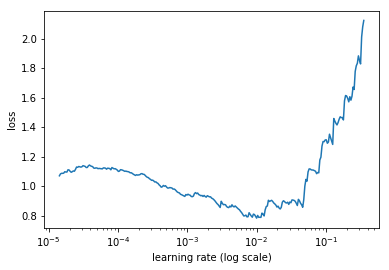

In [23]:
learn.sched.plot()

In [24]:
#we could try loading the previous trained model
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                    
    0      0.594592   0.781419   0.969816  


[array([0.78142]), 0.969816460207029]

In [25]:
learn.save('clas_5_0')

In [26]:
learn.load('clas_5_0')
learn.freeze_to(-2)
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                    
    0      0.819222   0.717978   0.964872  


[array([0.71798]), 0.964872103990032]

In [27]:
learn.save('clas_5_1')

In [ ]:
learn.load('clas_5_1')
learn.unfreeze()
learn.fit(lrs, 1, wds=wd, cycle_len=15, use_clr=(32,10))

epoch      trn_loss   val_loss   accuracy                    
    0      0.756578   0.746126   0.958475  
    1      0.652894   0.843086   0.96828                     
    2      0.769309   0.845199   0.975052                    
    3      0.590221   0.672936   0.977122                    
    4      0.471266   0.802307   0.979156                    
    5      0.378712   0.856909   0.975704                    
    6      0.396993   0.946511   0.977239                    
    7      0.40837    0.895451   0.975916                    
    8      0.421074   1.302438   0.978716                    
    9      0.309202   1.061349   0.975448                    
    10     0.27824    1.322541   0.975135                    
    11     0.415923   1.059349   0.980649                    
    12     0.150769   1.315518   0.980161                    
 46%|████▌     | 179/388 [02:01<02:29,  1.40it/s, loss=0.197]

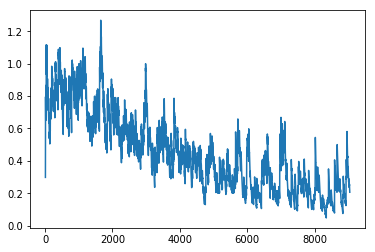

In [29]:
learn.save('clas_5_2')
learn.sched.plot_loss()

In [30]:
#alternatively, we could artificially increase the frequency of the negative comments by 
#balancing the data manually...

In [32]:
learn.fit(lrs, 1, wds=wd, cycle_len=5, use_clr=(32,10))

epoch      trn_loss   val_loss   accuracy                     
    0      0.356271   1.427584   0.983096  
    1      0.358175   2.778079   0.970651                    
    2      0.204753   0.874443   0.980651                     
    3      0.234984   1.029615   0.970442                     
  5%|▍         | 30/603 [00:14<03:12,  2.97it/s, loss=0.137]

KeyboardInterrupt: 